<a href="https://colab.research.google.com/github/avasiliki/search_news/blob/main/aetopoulou.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Εξάγωγή ειδήσεων από RSS feeds 5 ειδησεογραφικών καναλιών: enikos, naftemporiki, in,protothema και tanea.Στη συνέχεια αποθήκευση αυτών στο dataframe df.

In [ ]:
!pip install feedparser
from dateutil import parser
import feedparser
import requests
from bs4 import BeautifulSoup
import pandas as pd
import datetime
import time
import pytz
import re

     |████████████████████████████████| 81 kB 3.8 MB/s 
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6066 sha256=85048f01ec5ce81431dff6e1b209f9d89745713013940e79abc9bb67bdb81a1b
  Stored in directory: /root/.cache/pip/wheels/73/ad/a4/0dff4a6ef231fc0dfa12ffbac2a36cebfdddfe059f50e019aa
Successfully built sgmllib3k


In [ ]:
timeZ_At = pytz.timezone('Europe/Athens') #παίρνουμε τη ζώνη ώρας για την Ελλάδα
# Εξαγωγή ειδήσεων από το ειδησεογραφικό κανάλι enikos.gr
def read_enikos_rss():

 #URL προς απόξεση
 url_to_scrape="https://www.enikos.gr/feed/"
 NewsFeed = feedparser.parse(url_to_scrape)
 
 news_items=[]  
 for entry in NewsFeed.entries:
    news_item = {}
    news_item['title'] = entry.title
    news_item['category'] = entry.category
    news_item['description'] = entry.description
    news_item['link'] = entry.link
    datetime_rss = parser.parse(entry.published)
    datetime_timestamp = float(datetime_rss.astimezone(timeZ_At).strftime("%s"))    #μετατροπή ώρας στην τοπική
    local_datetime_converted = datetime.datetime.fromtimestamp(datetime_timestamp)  #μετατροπή ημερομηνίας/ώρας σε μορφή κοινή για όλα τα ειδησεογραφικά κανάλια
    news_item['pubDate'] = local_datetime_converted 

    #  Ανάγνωση του περιεχομένου των ειδήσεων 
    news = requests.get(entry.link)
    news_content = news.content  
    soup_news = BeautifulSoup(news_content, 'html.parser')
        
    b = soup_news.find_all('div', class_='articletext') 
    try:
       x=b[0].get_text()
    except IndexError:
       x = ""

    # Αφαίρεση κενών γραμμών από το περιεχόμενο
    lines = x.split("\n")
    non_empty_lines = [line for line in lines if line.strip() != ""]
    text_without_empty_lines = ""
    for line in non_empty_lines:
      text_without_empty_lines += line + " "
            
    news_item['content']= re.sub(r"http\S+", "", text_without_empty_lines)
    
    news_items.append(news_item)
 return news_items

# Εξαγωγή ειδήσεων από το ειδησεογραφικό κανάλι naftemporiki.gr
def read_naftemporiki_rss():

 #URL προς απόξεση
 url_to_scrape="https://www.naftemporiki.gr/rssFeed"
 NewsFeed = feedparser.parse(url_to_scrape)

 news_items=[]  
 for entry in NewsFeed.entries:
    news_item = {}
    news_item['title'] = entry.title
    news_item['category'] = ' '
    news_item['description'] = entry.description
    news_item['link'] = entry.link
    datetime_rss = parser.parse(entry.published)
    datetime_timestamp = float(datetime_rss.strftime("%s"))
    local_datetime_converted = datetime.datetime.fromtimestamp(datetime_timestamp) #μετατροπή ημερομηνίας/ώρας σε μορφή κοινή για όλα τα ειδησεογραφικά κανάλια
    news_item['pubDate'] = local_datetime_converted 

    #  Ανάγνωση του περιεχομένου των ειδήσεων 
    news = requests.get(entry.link)
    news_content = news.content   
    soup_news = BeautifulSoup(news_content, 'html.parser')
    b = soup_news.find_all('span', id='spBody')
    try:
       x = b[0].find_all(['p','li'])
    except IndexError:
       x = []

    # Ένωση των παραγράφων
    list_paragraphs = []
    final_article=" "
    for p in range(len(x)):
        paragraph = x[p].get_text() + " "
        list_paragraphs.append(paragraph) 
    final_article = " ".join(list_paragraphs)
    news_item['content']=final_article 
    
    news_items.append(news_item)
 return news_items

# Εξαγωγή ειδήσεων από το ειδησεογραφικό κανάλι in.gr 
def read_in_rss():

 #URL προς απόξεση
 url_to_scrape="https://www.in.gr/feed/"
 NewsFeed = feedparser.parse(url_to_scrape)

 news_items=[]  
 for entry in NewsFeed.entries:
    news_item = {}
    news_item['title'] = entry.title
    news_item['category'] = entry.category
    soup_description= BeautifulSoup(entry.description, 'html.parser')
    news_item['description'] = soup_description.get_text()  
    news_item['link'] = entry.link
    datetime_rss = parser.parse(entry.published)
    datetime_timestamp = float(datetime_rss.astimezone(timeZ_At).strftime("%s"))   #μετατροπή ώρας στην τοπική
    local_datetime_converted = datetime.datetime.fromtimestamp(datetime_timestamp) #μετατροπή ημερομηνίας/ώρας σε μορφή κοινή για όλα τα ειδησεογραφικά κανάλια
    news_item['pubDate'] = local_datetime_converted 

    #  Ανάγνωση του περιεχομένου των ειδήσεων 
    news = requests.get(entry.link)
    
    news_content = news.content   
    soup_news = BeautifulSoup(news_content, 'html.parser')
    #ανάγνωση ειδήσεων από το h2 tag στο πάνω  μέρος του άρθρου
    b1=soup_news.find_all('h2', class_='description' )
    #ανάγνωση του υπόλοιπου άρθρου ειδήσεων
    b = soup_news.find_all('div', itemprop='articleBody')

    # το άρθρο δεν έχει σταθερή μορφή    
    try:
      if len(b)==2:  # 1η μορφή
       x = b[1].find_all(["p","h1","h2","h3","h4"])
      else: # 2η μορφή
       x = b[0].find_all(["p","h1","h2","h3","h4"])
    except IndexError:
      x = []
     
           
    # Ένωση των παραγράφων
    list_paragraphs = []
    final_article="  "
    try:
      paragraph=b1[0].get_text() #κείμενο απο το h2 tag στο πάνω  μέρος του άρθρου     
    except:
      paragraph=""     
    list_paragraphs.append(paragraph) 

    if len(b)==2: # 1η μορφή
      for p in range(len(x)):
        paragraph = x[p].get_text() + " "
        list_paragraphs.append(paragraph) 
    else:  #2η μορφή
     try:
       paragraph = x[0].get_text() + " " 
     except:
       paragraph=""
     list_paragraphs.append(paragraph) 
    final_article = " ".join(list_paragraphs) #τελικό περιεχόμενο του άρθρου
    news_item['content']=final_article 
        
    news_items.append(news_item)
 return news_items




# Εξαγωγή ειδήσεων από το ειδησεογραφικό κανάλι protothema.gr 
def read_protothema_rss():

 #URL προς απόξεση
 url_to_scrape="https://www.protothema.gr/rss"
 NewsFeed = feedparser.parse(url_to_scrape)
 

 news_items=[]  
 for entry in NewsFeed.entries:
    news_item = {}
    news_item['title'] = entry.title
    news_item['category'] = entry.category
    soup_description= BeautifulSoup(entry.description, 'html.parser')
    news_item['description'] = soup_description.get_text()  
    news_item['link'] = entry.link
    datetime_rss = parser.parse(entry.published)
    datetime_timestamp = float(datetime_rss.strftime("%s"))
    local_datetime_converted = datetime.datetime.fromtimestamp(datetime_timestamp)  #μετατροπή ημερομηνίας/ώρας σε μορφή κοινή για όλα τα ειδησεογραφικά κανάλια
    news_item['pubDate'] = local_datetime_converted 

    #  Ανάγνωση του περιεχομένου των ειδήσεων 
    news = requests.get(entry.link)
    news_content = news.content   
    soup_news = BeautifulSoup(news_content, 'html.parser')
    for script in soup_news(['script']):
         script.decompose()    # rip it out
        
       
    #ανάγνωση ειδήσεων από το h3 tag στο πάνω  μέρος του άρθρου
    try:
      div_element = soup_news.find('div', class_='content details')
      children = div_element.findChildren('h3' , recursive=False)
      h3=children[0].get_text()
    except:
      h3=""
      
     
    #ανάγνωση του υπόλοιπου άρθρου ειδήσεων
    b = soup_news.find_all('div', class_='cntTxt')   
    try:
      x = b[0].get_text()
    except IndexError:
      x = ""
    #print(x)
    #print('-----------------------------------')
    # Αφαίρεση κενών γραμμών από το περιεχόμενο
    lines = x.split("\n")
    non_empty_lines = [line for line in lines if line.strip() != ""]
    text_without_empty_lines = h3 + " "
    for line in non_empty_lines:
      if line.find("Ειδήσεις σήμερα")!=-1 or line=="Ακολουθήστε το protothema.gr στο Google News και μάθετε πρώτοι όλες τις ειδήσεις" :
        break
      if line.find("Glomex Player")!=-1: 
        continue  
      text_without_empty_lines += line.strip() + " "
    #print(text_without_empty_lines)
    #print('========================')
    news_item['content']=text_without_empty_lines.replace('\n', ' ').strip()
    news_items.append(news_item)
 
 return news_items


# Εξαγωγή ειδήσεων από το ειδησεογραφικό κανάλι tanea.gr 
def read_tanea_rss():

 #URL προς απόξεση
 url_to_scrape="https://www.tanea.gr/rss"
 NewsFeed = feedparser.parse(url_to_scrape)

 news_items=[]  
 for entry in NewsFeed.entries:
    news_item = {}
    news_item['title'] = entry.title
    news_item['category'] = entry.category
    soup_description= BeautifulSoup(entry.description, 'html.parser')
    news_item['description'] = soup_description.get_text()
    news_item['link'] = entry.link
    datetime_rss = parser.parse(entry.published)
    datetime_timestamp = float(datetime_rss.astimezone(timeZ_At).strftime("%s"))     #μετατροπή ώρας στην τοπική
    local_datetime_converted = datetime.datetime.fromtimestamp(datetime_timestamp)   #μετατροπή ημερομηνίας/ώρας σε μορφή κοινή για όλα τα ειδησεογραφικά κανάλια
    news_item['pubDate'] = local_datetime_converted 
    soup_content= BeautifulSoup(entry.content[0]['value'], 'html.parser')             #εξαγωγή του περιεχομένου του άρθρου της είδησης
    news_item['content'] =news_item['description'] + soup_content.get_text().replace('\n', ' ')
    news_items.append(news_item)
 return news_items

#επανάληψη της διαδικασίας της εξαγωγής των ειδήσεων κάθε μία ώρα
while 1:
  #Δημιουργία dataframe df1 από τις ειδήσεις που έχουν εξαχθεί από το κανάλι enikos.gr 
 df = pd.DataFrame(read_enikos_rss(), columns=['title','category', 'description','link','content','pubDate'])
 try:
    df1=df1.append(df) #συνένωση με το dataframe df1 της προηγούμενης επανάληψης
 except:
    df1=df 
 df1=df1.drop_duplicates(subset ="title") #αφαίρεση διπλότυπων ειδήσεων
 
 #Δημιουργία dataframe df2 από τις ειδήσεις που έχουν εξαχθεί από το κανάλι naftemporiki.gr  
 df = pd.DataFrame(read_naftemporiki_rss(), columns=['title','category', 'description','link','content','pubDate'])
 try:
    df2=df2.append(df) #συνένωση με το dataframe df2 της προηγούμενης επανάληψης
 except:
    df2=df 
 df2=df2.drop_duplicates(subset ="title") #αφαίρεση διπλότυπων ειδήσεων
 
 #Δημιουργία dataframe df3 από τις ειδήσεις που έχουν εξαχθεί από το κανάλι in.gr  
 df = pd.DataFrame(read_in_rss(), columns=['title','category', 'description','link','content','pubDate'])
 try:
    df3=df3.append(df)  #συνένωση με το dataframe df3 της προηγούμενης επανάληψης
 except:
    df3=df 
 df3=df3.drop_duplicates(subset ="title")  #αφαίρεση διπλότυπων ειδήσεων
 
 #Δημιουργία dataframe df4 από τις ειδήσεις που έχουν εξαχθεί από το κανάλι protothema.gr  
 df = pd.DataFrame(read_protothema_rss(), columns=['title','category', 'description','link','content','pubDate'])
 try:
    df4=df4.append(df)  #συνένωση με το dataframe df4 της προηγούμενης επανάληψης
 except:
    df4=df 
 df4=df4.drop_duplicates(subset ="title") #αφαίρεση διπλότυπων ειδήσεων
 
 #Δημιουργία dataframe df5 από τις ειδήσεις που έχουν εξαχθεί από το κανάλι tanea.gr  
 df = pd.DataFrame(read_tanea_rss(), columns=['title','category', 'description','link','content','pubDate'])
 try:
    df5=df5.append(df)  #συνένωση με το dataframe df5 της προηγούμενης επανάληψης
 except:
    df5=df 
 df5=df5.drop_duplicates(subset ="title")  #αφαίρεση διπλότυπων ειδήσεων 
  
 #συνένωση των dataframes df1, df2, df3, df4, df5
 frames = [df1, df2, df3,df4,df5]
 df = pd.concat(frames)
 df.reset_index(drop=True, inplace=True)

 display(df)
 time.sleep(20*60) #επανάληψη της διαδικασίας εξαγωγής των ειδήσεων κάθε μία ώρα

title  ...             pubDate
0    Πού εντοπίστηκαν τα 9.596 νέα κρούσματα – Η γε...  ... 2022-02-20 16:57:40
1    Μεσσηνία: Χτύπησαν τον 73χρονο με “κάβουρα” κα...  ... 2022-02-20 16:56:34
2    Στα 9.596 τα νέα κρούσματα κορονοϊού – 67 νεκρ...  ... 2022-02-20 16:48:38
3    Πάτρα: “Η Μαλένα είναι αγγελάκι στον ουρανό” –...  ... 2022-02-20 16:38:02
4    Ο Σάκης Τανιμανίδης τρολάρει την Χριστίνα Μπόμ...  ... 2022-02-20 16:30:09
..                                                 ...  ...                 ...
229  Πάτρα: Νέα στοιχεία για το θρίλερ με τα νεκρά ...  ... 2022-02-19 21:17:33
230                       Editorial: The great dilemma  ... 2022-02-19 21:05:03
231  Καταιγίδα «Γιούνις»: Προκάλεσε το θάνατο 14 αν...  ... 2022-02-19 20:28:32
232  Κυριάκος Μητσοτάκης – Κάμαλα Χάρις: Ελληνοαμερ...  ... 2022-02-19 20:22:11
233  Προφυλακίστηκε η 19χρονη που εξέδιδε την ίδια ...  ... 2022-02-19 19:54:49

[234 rows x 6 columns]

title  ...             pubDate
0    Πού εντοπίστηκαν τα 9.596 νέα κρούσματα – Η γε...  ... 2022-02-20 16:57:40
1    Μεσσηνία: Χτύπησαν τον 73χρονο με “κάβουρα” κα...  ... 2022-02-20 16:56:34
2    Στα 9.596 τα νέα κρούσματα κορονοϊού – 67 νεκρ...  ... 2022-02-20 16:48:38
3    Πάτρα: “Η Μαλένα είναι αγγελάκι στον ουρανό” –...  ... 2022-02-20 16:38:02
4    Ο Σάκης Τανιμανίδης τρολάρει την Χριστίνα Μπόμ...  ... 2022-02-20 16:30:09
..                                                 ...  ...                 ...
254  Κυριάκος Μητσοτάκης – Κάμαλα Χάρις: Ελληνοαμερ...  ... 2022-02-19 20:22:11
255  Προφυλακίστηκε η 19χρονη που εξέδιδε την ίδια ...  ... 2022-02-19 19:54:49
256  Παράθυρο για αποκλιμάκωση της έντασης στην Ουκ...  ... 2022-02-20 17:29:18
257  Ηλιόπουλος: Ο Χατζηδάκης «πουλάει τρέλα» για τ...  ... 2022-02-20 17:23:17
258  Αγρίνιο: Συγκλονίζει ο πατέρας του 16χρονου πο...  ... 2022-02-20 17:10:44

[259 rows x 6 columns]

title  ...             pubDate
0    Πού εντοπίστηκαν τα 9.596 νέα κρούσματα – Η γε...  ... 2022-02-20 16:57:40
1    Μεσσηνία: Χτύπησαν τον 73χρονο με “κάβουρα” κα...  ... 2022-02-20 16:56:34
2    Στα 9.596 τα νέα κρούσματα κορονοϊού – 67 νεκρ...  ... 2022-02-20 16:48:38
3    Πάτρα: “Η Μαλένα είναι αγγελάκι στον ουρανό” –...  ... 2022-02-20 16:38:02
4    Ο Σάκης Τανιμανίδης τρολάρει την Χριστίνα Μπόμ...  ... 2022-02-20 16:30:09
..                                                 ...  ...                 ...
275  Προφυλακίστηκε η 19χρονη που εξέδιδε την ίδια ...  ... 2022-02-19 19:54:49
276  Παράθυρο για αποκλιμάκωση της έντασης στην Ουκ...  ... 2022-02-20 17:29:18
277  Ηλιόπουλος: Ο Χατζηδάκης «πουλάει τρέλα» για τ...  ... 2022-02-20 17:23:17
278  Αγρίνιο: Συγκλονίζει ο πατέρας του 16χρονου πο...  ... 2022-02-20 17:10:44
279      Εντοπίστηκε νεκρός άνδρας στο φλεγόμενο πλοίο  ... 2022-02-20 17:39:40

[280 rows x 6 columns]

title  ...             pubDate
0    Πού εντοπίστηκαν τα 9.596 νέα κρούσματα – Η γε...  ... 2022-02-20 16:57:40
1    Μεσσηνία: Χτύπησαν τον 73χρονο με “κάβουρα” κα...  ... 2022-02-20 16:56:34
2    Στα 9.596 τα νέα κρούσματα κορονοϊού – 67 νεκρ...  ... 2022-02-20 16:48:38
3    Πάτρα: “Η Μαλένα είναι αγγελάκι στον ουρανό” –...  ... 2022-02-20 16:38:02
4    Ο Σάκης Τανιμανίδης τρολάρει την Χριστίνα Μπόμ...  ... 2022-02-20 16:30:09
..                                                 ...  ...                 ...
291  Προφυλακίστηκε η 19χρονη που εξέδιδε την ίδια ...  ... 2022-02-19 19:54:49
292  Παράθυρο για αποκλιμάκωση της έντασης στην Ουκ...  ... 2022-02-20 17:29:18
293  Ηλιόπουλος: Ο Χατζηδάκης «πουλάει τρέλα» για τ...  ... 2022-02-20 17:23:17
294  Αγρίνιο: Συγκλονίζει ο πατέρας του 16χρονου πο...  ... 2022-02-20 17:10:44
295      Εντοπίστηκε νεκρός άνδρας στο φλεγόμενο πλοίο  ... 2022-02-20 17:39:40

[296 rows x 6 columns]

title  ...             pubDate
0    Πού εντοπίστηκαν τα 9.596 νέα κρούσματα – Η γε...  ... 2022-02-20 16:57:40
1    Μεσσηνία: Χτύπησαν τον 73χρονο με “κάβουρα” κα...  ... 2022-02-20 16:56:34
2    Στα 9.596 τα νέα κρούσματα κορονοϊού – 67 νεκρ...  ... 2022-02-20 16:48:38
3    Πάτρα: “Η Μαλένα είναι αγγελάκι στον ουρανό” –...  ... 2022-02-20 16:38:02
4    Ο Σάκης Τανιμανίδης τρολάρει την Χριστίνα Μπόμ...  ... 2022-02-20 16:30:09
..                                                 ...  ...                 ...
316  Αγρίνιο: Συγκλονίζει ο πατέρας του 16χρονου πο...  ... 2022-02-20 17:10:44
317      Εντοπίστηκε νεκρός άνδρας στο φλεγόμενο πλοίο  ... 2022-02-20 17:39:40
318  «Κωλοτούμπα» της Τουρκίας για τους ρωσικούς S-...  ... 2022-02-20 18:35:37
319  Πέτρος Φιλιππίδης: Επιστολή από τους δικηγόρου...  ... 2022-02-20 18:28:59
320  Καρφιά Τσακαλώτου: Ανασφαλής ο Τσίπρας - Χειρό...  ... 2022-02-20 18:19:05

[321 rows x 6 columns]

title  ...             pubDate
0    Πού εντοπίστηκαν τα 9.596 νέα κρούσματα – Η γε...  ... 2022-02-20 16:57:40
1    Μεσσηνία: Χτύπησαν τον 73χρονο με “κάβουρα” κα...  ... 2022-02-20 16:56:34
2    Στα 9.596 τα νέα κρούσματα κορονοϊού – 67 νεκρ...  ... 2022-02-20 16:48:38
3    Πάτρα: “Η Μαλένα είναι αγγελάκι στον ουρανό” –...  ... 2022-02-20 16:38:02
4    Ο Σάκης Τανιμανίδης τρολάρει την Χριστίνα Μπόμ...  ... 2022-02-20 16:30:09
..                                                 ...  ...                 ...
341      Εντοπίστηκε νεκρός άνδρας στο φλεγόμενο πλοίο  ... 2022-02-20 17:39:40
342  «Κωλοτούμπα» της Τουρκίας για τους ρωσικούς S-...  ... 2022-02-20 18:35:37
343  Πέτρος Φιλιππίδης: Επιστολή από τους δικηγόρου...  ... 2022-02-20 18:28:59
344  Καρφιά Τσακαλώτου: Ανασφαλής ο Τσίπρας - Χειρό...  ... 2022-02-20 18:19:05
345  «Ο Πούτιν σχεδιάζει συλλήψεις και δολοφονίες σ...  ... 2022-02-20 18:59:03

[346 rows x 6 columns]

title  ...             pubDate
0    Πού εντοπίστηκαν τα 9.596 νέα κρούσματα – Η γε...  ... 2022-02-20 16:57:40
1    Μεσσηνία: Χτύπησαν τον 73χρονο με “κάβουρα” κα...  ... 2022-02-20 16:56:34
2    Στα 9.596 τα νέα κρούσματα κορονοϊού – 67 νεκρ...  ... 2022-02-20 16:48:38
3    Πάτρα: “Η Μαλένα είναι αγγελάκι στον ουρανό” –...  ... 2022-02-20 16:38:02
4    Ο Σάκης Τανιμανίδης τρολάρει την Χριστίνα Μπόμ...  ... 2022-02-20 16:30:09
..                                                 ...  ...                 ...
372  Καρφιά Τσακαλώτου: Ανασφαλής ο Τσίπρας - Χειρό...  ... 2022-02-20 18:19:05
373  «Ο Πούτιν σχεδιάζει συλλήψεις και δολοφονίες σ...  ... 2022-02-20 18:59:03
374  Σημαντική δωρεά μηχανημάτων στο νοσοκομείο «Αγ...  ... 2022-02-20 19:19:08
375  Παναθηναϊκός – Ολυμπιακός 73-81: Πήρε το Κύπελ...  ... 2022-02-20 19:08:01
376  Δημήτρης Σοροπάνης: Έφυγε από τη ζωή ο 28χρονο...  ... 2022-02-20 19:04:19

[377 rows x 6 columns]

title  ...             pubDate
0    Πού εντοπίστηκαν τα 9.596 νέα κρούσματα – Η γε...  ... 2022-02-20 16:57:40
1    Μεσσηνία: Χτύπησαν τον 73χρονο με “κάβουρα” κα...  ... 2022-02-20 16:56:34
2    Στα 9.596 τα νέα κρούσματα κορονοϊού – 67 νεκρ...  ... 2022-02-20 16:48:38
3    Πάτρα: “Η Μαλένα είναι αγγελάκι στον ουρανό” –...  ... 2022-02-20 16:38:02
4    Ο Σάκης Τανιμανίδης τρολάρει την Χριστίνα Μπόμ...  ... 2022-02-20 16:30:09
..                                                 ...  ...                 ...
398  Σημαντική δωρεά μηχανημάτων στο νοσοκομείο «Αγ...  ... 2022-02-20 19:19:08
399  Παναθηναϊκός – Ολυμπιακός 73-81: Πήρε το Κύπελ...  ... 2022-02-20 19:08:01
400  Δημήτρης Σοροπάνης: Έφυγε από τη ζωή ο 28χρονο...  ... 2022-02-20 19:04:19
401  Μύθοι και ψέματα για το οχτάωρο και την τετραή...  ... 2022-02-20 19:43:06
402  Όταν το σύνδρομο Μινχάουζεν δια αντιπροσώπου ε...  ... 2022-02-20 19:36:50

[403 rows x 6 columns]

title  ...             pubDate
0    Πού εντοπίστηκαν τα 9.596 νέα κρούσματα – Η γε...  ... 2022-02-20 16:57:40
1    Μεσσηνία: Χτύπησαν τον 73χρονο με “κάβουρα” κα...  ... 2022-02-20 16:56:34
2    Στα 9.596 τα νέα κρούσματα κορονοϊού – 67 νεκρ...  ... 2022-02-20 16:48:38
3    Πάτρα: “Η Μαλένα είναι αγγελάκι στον ουρανό” –...  ... 2022-02-20 16:38:02
4    Ο Σάκης Τανιμανίδης τρολάρει την Χριστίνα Μπόμ...  ... 2022-02-20 16:30:09
..                                                 ...  ...                 ...
425  Δημήτρης Σοροπάνης: Έφυγε από τη ζωή ο 28χρονο...  ... 2022-02-20 19:04:19
426  Μύθοι και ψέματα για το οχτάωρο και την τετραή...  ... 2022-02-20 19:43:06
427  Όταν το σύνδρομο Μινχάουζεν δια αντιπροσώπου ε...  ... 2022-02-20 19:36:50
428  Θεσσαλονίκη: Επιτέθηκαν σε λεωφορείο πετώντας ...  ... 2022-02-20 20:05:43
429  Ελληνας ο νεκρός του Euroferry Olympia – Αναγν...  ... 2022-02-20 19:52:56

[430 rows x 6 columns]

title  ...             pubDate
0    Πού εντοπίστηκαν τα 9.596 νέα κρούσματα – Η γε...  ... 2022-02-20 16:57:40
1    Μεσσηνία: Χτύπησαν τον 73χρονο με “κάβουρα” κα...  ... 2022-02-20 16:56:34
2    Στα 9.596 τα νέα κρούσματα κορονοϊού – 67 νεκρ...  ... 2022-02-20 16:48:38
3    Πάτρα: “Η Μαλένα είναι αγγελάκι στον ουρανό” –...  ... 2022-02-20 16:38:02
4    Ο Σάκης Τανιμανίδης τρολάρει την Χριστίνα Μπόμ...  ... 2022-02-20 16:30:09
..                                                 ...  ...                 ...
440  Δημήτρης Σοροπάνης: Έφυγε από τη ζωή ο 28χρονο...  ... 2022-02-20 19:04:19
441  Μύθοι και ψέματα για το οχτάωρο και την τετραή...  ... 2022-02-20 19:43:06
442  Όταν το σύνδρομο Μινχάουζεν δια αντιπροσώπου ε...  ... 2022-02-20 19:36:50
443  Θεσσαλονίκη: Επιτέθηκαν σε λεωφορείο πετώντας ...  ... 2022-02-20 20:05:43
444  Ελληνας ο νεκρός του Euroferry Olympia – Αναγν...  ... 2022-02-20 19:52:56

[445 rows x 6 columns]

title  ...             pubDate
0    Πού εντοπίστηκαν τα 9.596 νέα κρούσματα – Η γε...  ... 2022-02-20 16:57:40
1    Μεσσηνία: Χτύπησαν τον 73χρονο με “κάβουρα” κα...  ... 2022-02-20 16:56:34
2    Στα 9.596 τα νέα κρούσματα κορονοϊού – 67 νεκρ...  ... 2022-02-20 16:48:38
3    Πάτρα: “Η Μαλένα είναι αγγελάκι στον ουρανό” –...  ... 2022-02-20 16:38:02
4    Ο Σάκης Τανιμανίδης τρολάρει την Χριστίνα Μπόμ...  ... 2022-02-20 16:30:09
..                                                 ...  ...                 ...
462  Μύθοι και ψέματα για το οχτάωρο και την τετραή...  ... 2022-02-20 19:43:06
463  Όταν το σύνδρομο Μινχάουζεν δια αντιπροσώπου ε...  ... 2022-02-20 19:36:50
464  Θεσσαλονίκη: Επιτέθηκαν σε λεωφορείο πετώντας ...  ... 2022-02-20 20:05:43
465  Ελληνας ο νεκρός του Euroferry Olympia – Αναγν...  ... 2022-02-20 19:52:56
466          Veloqx Fangio: Η Ferrari F12 αλά κινέζικα  ... 2022-02-20 20:35:11

[467 rows x 6 columns]

title  ...             pubDate
0    Πού εντοπίστηκαν τα 9.596 νέα κρούσματα – Η γε...  ... 2022-02-20 16:57:40
1    Μεσσηνία: Χτύπησαν τον 73χρονο με “κάβουρα” κα...  ... 2022-02-20 16:56:34
2    Στα 9.596 τα νέα κρούσματα κορονοϊού – 67 νεκρ...  ... 2022-02-20 16:48:38
3    Πάτρα: “Η Μαλένα είναι αγγελάκι στον ουρανό” –...  ... 2022-02-20 16:38:02
4    Ο Σάκης Τανιμανίδης τρολάρει την Χριστίνα Μπόμ...  ... 2022-02-20 16:30:09
..                                                 ...  ...                 ...
480  Όταν το σύνδρομο Μινχάουζεν δια αντιπροσώπου ε...  ... 2022-02-20 19:36:50
481  Θεσσαλονίκη: Επιτέθηκαν σε λεωφορείο πετώντας ...  ... 2022-02-20 20:05:43
482  Ελληνας ο νεκρός του Euroferry Olympia – Αναγν...  ... 2022-02-20 19:52:56
483          Veloqx Fangio: Η Ferrari F12 αλά κινέζικα  ... 2022-02-20 20:35:11
484  To θρυλικό "σκαθάρι" της VW, που είχε βάλει τέ...  ... 2022-02-20 20:52:49

[485 rows x 6 columns]

title  ...             pubDate
0    Πού εντοπίστηκαν τα 9.596 νέα κρούσματα – Η γε...  ... 2022-02-20 16:57:40
1    Μεσσηνία: Χτύπησαν τον 73χρονο με “κάβουρα” κα...  ... 2022-02-20 16:56:34
2    Στα 9.596 τα νέα κρούσματα κορονοϊού – 67 νεκρ...  ... 2022-02-20 16:48:38
3    Πάτρα: “Η Μαλένα είναι αγγελάκι στον ουρανό” –...  ... 2022-02-20 16:38:02
4    Ο Σάκης Τανιμανίδης τρολάρει την Χριστίνα Μπόμ...  ... 2022-02-20 16:30:09
..                                                 ...  ...                 ...
499  Θεσσαλονίκη: Επιτέθηκαν σε λεωφορείο πετώντας ...  ... 2022-02-20 20:05:43
500  Ελληνας ο νεκρός του Euroferry Olympia – Αναγν...  ... 2022-02-20 19:52:56
501          Veloqx Fangio: Η Ferrari F12 αλά κινέζικα  ... 2022-02-20 20:35:11
502  To θρυλικό "σκαθάρι" της VW, που είχε βάλει τέ...  ... 2022-02-20 20:52:49
503  Αποκλειστικό MEGA: Νέα συγκλονιστικά ντοκουμέν...  ... 2022-02-20 21:29:43

[504 rows x 6 columns]

title  ...             pubDate
0    Πού εντοπίστηκαν τα 9.596 νέα κρούσματα – Η γε...  ... 2022-02-20 16:57:40
1    Μεσσηνία: Χτύπησαν τον 73χρονο με “κάβουρα” κα...  ... 2022-02-20 16:56:34
2    Στα 9.596 τα νέα κρούσματα κορονοϊού – 67 νεκρ...  ... 2022-02-20 16:48:38
3    Πάτρα: “Η Μαλένα είναι αγγελάκι στον ουρανό” –...  ... 2022-02-20 16:38:02
4    Ο Σάκης Τανιμανίδης τρολάρει την Χριστίνα Μπόμ...  ... 2022-02-20 16:30:09
..                                                 ...  ...                 ...
514          Veloqx Fangio: Η Ferrari F12 αλά κινέζικα  ... 2022-02-20 20:35:11
515  To θρυλικό "σκαθάρι" της VW, που είχε βάλει τέ...  ... 2022-02-20 20:52:49
516  Αποκλειστικό MEGA: Νέα συγκλονιστικά ντοκουμέν...  ... 2022-02-20 21:29:43
517  «Ο Πούτιν έδωσε εντολή για εισβολής στην Ουκρα...  ... 2022-02-20 21:55:32
518  Συναγερμός για 40 παιδιά «φαντάσματα» που απου...  ... 2022-02-20 21:51:50

[519 rows x 6 columns]

title  ...             pubDate
0    Πού εντοπίστηκαν τα 9.596 νέα κρούσματα – Η γε...  ... 2022-02-20 16:57:40
1    Μεσσηνία: Χτύπησαν τον 73χρονο με “κάβουρα” κα...  ... 2022-02-20 16:56:34
2    Στα 9.596 τα νέα κρούσματα κορονοϊού – 67 νεκρ...  ... 2022-02-20 16:48:38
3    Πάτρα: “Η Μαλένα είναι αγγελάκι στον ουρανό” –...  ... 2022-02-20 16:38:02
4    Ο Σάκης Τανιμανίδης τρολάρει την Χριστίνα Μπόμ...  ... 2022-02-20 16:30:09
..                                                 ...  ...                 ...
542  «Ο Πούτιν έδωσε εντολή για εισβολής στην Ουκρα...  ... 2022-02-20 21:55:32
543  Συναγερμός για 40 παιδιά «φαντάσματα» που απου...  ... 2022-02-20 21:51:50
544  Κέρκυρα: Φόβοι για διαρροή καυσίμου από το Eur...  ... 2022-02-20 22:20:56
545  Θάνατος τριών παιδιών στην Πάτρα: Παγκόσμιο φα...  ... 2022-02-20 22:04:43
546  Γλυκά Νερά: Πώς ξεκίνησε η σκηνοθεσία του εγκλ...  ... 2022-02-20 22:00:26

[547 rows x 6 columns]

title  ...             pubDate
0    Πού εντοπίστηκαν τα 9.596 νέα κρούσματα – Η γε...  ... 2022-02-20 16:57:40
1    Μεσσηνία: Χτύπησαν τον 73χρονο με “κάβουρα” κα...  ... 2022-02-20 16:56:34
2    Στα 9.596 τα νέα κρούσματα κορονοϊού – 67 νεκρ...  ... 2022-02-20 16:48:38
3    Πάτρα: “Η Μαλένα είναι αγγελάκι στον ουρανό” –...  ... 2022-02-20 16:38:02
4    Ο Σάκης Τανιμανίδης τρολάρει την Χριστίνα Μπόμ...  ... 2022-02-20 16:30:09
..                                                 ...  ...                 ...
556  «Ο Πούτιν έδωσε εντολή για εισβολής στην Ουκρα...  ... 2022-02-20 21:55:32
557  Συναγερμός για 40 παιδιά «φαντάσματα» που απου...  ... 2022-02-20 21:51:50
558  Κέρκυρα: Φόβοι για διαρροή καυσίμου από το Eur...  ... 2022-02-20 22:20:56
559  Θάνατος τριών παιδιών στην Πάτρα: Παγκόσμιο φα...  ... 2022-02-20 22:04:43
560  Γλυκά Νερά: Πώς ξεκίνησε η σκηνοθεσία του εγκλ...  ... 2022-02-20 22:00:26

[561 rows x 6 columns]

title  ...             pubDate
0    Πού εντοπίστηκαν τα 9.596 νέα κρούσματα – Η γε...  ... 2022-02-20 16:57:40
1    Μεσσηνία: Χτύπησαν τον 73χρονο με “κάβουρα” κα...  ... 2022-02-20 16:56:34
2    Στα 9.596 τα νέα κρούσματα κορονοϊού – 67 νεκρ...  ... 2022-02-20 16:48:38
3    Πάτρα: “Η Μαλένα είναι αγγελάκι στον ουρανό” –...  ... 2022-02-20 16:38:02
4    Ο Σάκης Τανιμανίδης τρολάρει την Χριστίνα Μπόμ...  ... 2022-02-20 16:30:09
..                                                 ...  ...                 ...
571  Συναγερμός για 40 παιδιά «φαντάσματα» που απου...  ... 2022-02-20 21:51:50
572  Κέρκυρα: Φόβοι για διαρροή καυσίμου από το Eur...  ... 2022-02-20 22:20:56
573  Θάνατος τριών παιδιών στην Πάτρα: Παγκόσμιο φα...  ... 2022-02-20 22:04:43
574  Γλυκά Νερά: Πώς ξεκίνησε η σκηνοθεσία του εγκλ...  ... 2022-02-20 22:00:26
575  Κοροναϊός: Τετραψήφιος αριθμός κρουσμάτων μετά...  ... 2022-02-20 22:56:32

[576 rows x 6 columns]

title  ...             pubDate
0    Πού εντοπίστηκαν τα 9.596 νέα κρούσματα – Η γε...  ... 2022-02-20 16:57:40
1    Μεσσηνία: Χτύπησαν τον 73χρονο με “κάβουρα” κα...  ... 2022-02-20 16:56:34
2    Στα 9.596 τα νέα κρούσματα κορονοϊού – 67 νεκρ...  ... 2022-02-20 16:48:38
3    Πάτρα: “Η Μαλένα είναι αγγελάκι στον ουρανό” –...  ... 2022-02-20 16:38:02
4    Ο Σάκης Τανιμανίδης τρολάρει την Χριστίνα Μπόμ...  ... 2022-02-20 16:30:09
..                                                 ...  ...                 ...
588  Θάνατος τριών παιδιών στην Πάτρα: Παγκόσμιο φα...  ... 2022-02-20 22:04:43
589  Γλυκά Νερά: Πώς ξεκίνησε η σκηνοθεσία του εγκλ...  ... 2022-02-20 22:00:26
590  Κοροναϊός: Τετραψήφιος αριθμός κρουσμάτων μετά...  ... 2022-02-20 22:56:32
591  Καρδίτσα: Απήγαγαν 26χρονη, την κακοποίησαν κα...  ... 2022-02-20 23:13:49
592  Credit Suisse: Διαρροή 18.000 λογαριασμών αποκ...  ... 2022-02-20 23:09:06

[593 rows x 6 columns]

KeyboardInterrupt: ignored

# Προεπεξεργασία ειδήσεων

In [ ]:
import re
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import unicodedata as ud
!pip install greek-stemmer
from greek_stemmer import GreekStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
  Created wheel for greek-stemmer: filename=greek_stemmer-0.1.1-py3-none-any.whl size=6738 sha256=442d66f9d515068bc661417008687ff979a0f2d76e1a1e0244d67a54f7eb85db
  Stored in directory: /root/.cache/pip/wheels/c5/39/16/eec6bf21a071c9e3ff11cda038b91d33fcce20a0b7378f64ac
Successfully built greek-stemmer


In [ ]:
stemmer = GreekStemmer()  # stemmer για την ελληνική γλώσσα

stopWordsGreek = stopwords.words('greek')      # Λήψη της λίστας με τις ελληνικές στοπ λέξεις 
stopWordsEnglish = stopwords.words('english')  # Λήψη της λίστας με τις αγγλικές στοπ λέξεις 
stopWords=stopWordsGreek + stopWordsEnglish

# Προσθήκη νέων stop λέξεων στη λίστα
stopWords.extend(['ακόμη','ακόμα','ακριβώς','αλλά','άλλος', 'αλλού','άλλα','άλλη','άλλο','άλλοι','άλλων','άλλους','άλλες','άμεσα','αμέσως','αν','ανά','ανάμεσα','αναφέρει','ανέφερε','αντ', 'αντί','αντίθετα','αντίστοιχα','άνω', 'από','απ','άρα','αργά','αργότερα','αρκετά','αρκετός','αρκετή','αρκετοί','αρκετές','αρκετό','αρκετών','αρκετούς','αρχικά','αρχικό','αρχική','αρχικός','αρχικοί','αρχικές','αρχικούς','αρχικών','ας','αφορά','αφού','αφότου','αύριο', 'αυτά', 'αυτές', 'αυτή','αυτήν', 'αυτό', 'αυτοί', 'αυτός', 'αυτούς', 'αυτών','αυτόν','αυτής','αυτού','βέβαια','γενικά','γενικώς','γρ','για','γιατί','γι','γίνομαι','γίνεται','γρήγορα','γύρω','διαβάστε','δηλαδή','δήλωσε','δε','δει','δείτε','δειτε','δεν','δικό','δικός','δική','δικοί','δικούς','δικών','διότι','δίπλα','δύο','δυο',
                   'εάν','εαυτόν','εαυτό','έγκαιρα','εγκαίρως','εδώ','εδω','είδα','είδες','είδε','είδαμε','είδατε','είδαν','είδανε','ειδικά','είπα','είπες','είπε','είπαμε','είπατε','είπαν','εκ','έκανε','έκαναν','έγινε','έγιναν','εν','εντός','έναντι','ένα','έναν','ένας','ενός','ενόψει','επί','επι','επιπλέον','εκεί', 'εγώ','εσύ','είμαι', 'είμαστε', 'είναι', 'είσαι', 'είστε', 'εκείνα', 'εκείνες', 'εκείνη','εκείνο', 'εκείνος', 'εκείνοι', 'εκείνους', 'εκείνων','εμάς','εσάς','εμείς','εσείς','εξάλλου','εξής','έξω','έπειτα','επίσης','επιπλέον','επειδή','επομένως','έπρεπε', 'ενώ','εμένα','εσένα','εσυ','έτσι', 'έως','είπε', 'είπαμε','είπατε','είπαν',
                   'είτε','εκτός','εμπρός','εντελώς','έχω','έχεις','έχει','έχουμε','έχετε','έχουν','είχε','είχαν','είχα','είχαμε','είχατε','είχες','ευρέως','εφόσον','ήμουν','ήσουν','ήταν','η','ή', 'ήδη','θα','ίδια','ίδιος','ίδιο','ίδιες','ίδιοι', 'ιδίως','ίσα','ίσια','ίσως', 'και', 'κάνω','κάνεις','κάνει','κάνουμε','κάνετε','κάνουν','κάθε', 'καθένας','καθεμια','καθεμία','καθόλου','καθώς','καλά','κακά', 'καμία','καμια','κατά','κι','καν','κανείς','κανένας','κανένα','κάποιος','κάποια','κάποιο','κάποιοι','κάποιες','κάποτε','κάτι','κάτω','κιόλας','κοντά','κυρίως','λέει','λένε','λιγάκι','λίγο','λίγες','λίγων','λίγοι','λίγα','λίγος','λίγης','λίγους','λιγότερο',
                   'λιγότερα','λιγότερος','λιγότεροι','λιγότερη','λιγότερες','λιγότερων','λοιπόν','λόγω','μαζί','μάλιστα','μάλλον','μέσα','μέσω','μεταξύ','μετά','μέχρι','μη','μήπως','μίλησε','μόλις','μας','μένα' ,'με','μερικοί','μερικών','μερικούς','μερικές','μερικά','μολονότι','μην','μόνο','μόνον','μόνος','μόνη','μου','μια','μία','μιας','μίας','μπορώ','μπορείς','μπορεί','μπορούμε','μπορείτε','μπορούν','νά','να','ναι','νομίζω','νομίζεις','νομίζει','νομίζουμε','νομίζετε','νομίζουν','νωρίς','νωρίτερα','ξανά', 'ο', 'οι','όλο','όλος','όλη','όλοι','όλες','όλα','όλους','όλων','όμως','όντως','όπου','οποία','οποίο','οποίος','οποίων','οποίους','οποίοι','οποίου','οποίες',
                   'οπότε','όπως','ορισμένο','ορισμένα','ορισμένοι','ορισμένες','όσο','όσος','όση','όσα','όσες','όσοι','όσων','όσους','όσον','όποιος','όποιο','όποια','όποιο','όποιων','όποιοι','όποιους','όποιες','οποιοσδήποτε','οποιαδήποτε','οποιοδήποτε','οποιουδήποτε','οποιασδήποτε','οποιοιδήποτε','οποιεσδήποτε','οποιωνδήποτε','οποιουσδήποτε','ος', 'ότι', 'ό,τι','όταν','ούτε','όχι','πάντα','πάλι','πάνω','πάρα','παρακολουθήστε','παρόλα','παρόλο','πει','πέρα','περίπου','περισσότερα','πια','πίσω','πιθανό','πιθανόν','ποια','ποιες', 'ποιο', 'ποιοι','ποιόν','ποιος','ποιον', 'πότε','ποτέ','πιο','πλέον','ποιους', 'ποιων','πόσο','πόσος','πόση','πόσα','πόσοι','πόσες','που','πού',
                   'πολύ','πολλοί','πολλά','πολλών','πολλούς','πολλές','πράγματι','πρέπει','πριν','πρόκειται','προτού','πως','πώς','σαν','σας','σε','σου','σιγά','σήμερα', 'στη', 'στην', 'στο', 'στον', 'στα','στιγμή','στις','στους','συ','σύμφωνα','συνεπώς','συνέχεια','συνεχώς','συνήθως','συχνά','σχεδόν','σχετικός','σχετική','σχετικό','σωστά','τα','ταυτόχρονα','ταυτόχρονη','τελικά','το', 'την', 'τη','τι', 'τις','της','των','τέτοιο','τέτοια','τέτοιος','τέτοιοι','τέτοιων','τέτοιους','τέτοιες','τέτοιον','τίποτα','τόνισε','τόνισαν','τουλάχιστον','τόσο','τόσα','τόσος','τόση','τόσοι','τόσων','τόσους','τόσες','τούτος','τούτη','τούτο','τούτα','τούτες','τον',
                   'τότε', 'του', 'τους','τώρα','υπάρχει','υπάρξει','υπάρχουν','υπό','ύστερα','ως','ώσπου','ώστε','ωστόσο','προς','μία','φαίνεται','φορά','φυσικά','χαμηλά','χάρη','χθες','χωρίς', 'proto', 'thema','Πηγή:www.gazzetta.gr','Πηγή: ΑΠΕ-ΜΠΕ','marieclaire','gr','www','gazzetta','com','πηγή','απε','μπε','pic','twitter','live','view','post','instagram','shared','ygeiamou','epiruspostgr','https'])

d = {ord('\N{COMBINING ACUTE ACCENT}'):None} # για την αφαίρεση τόνων από τις ελληνικές λεξεις

In [ ]:
# συνάρτηση για δημιουργία tokens και καθαρισμός του κειμένου
def tokenize_only(str_input):
    bagOfWords = nltk.word_tokenize(str_input) # δημιουργία tokens
    
    clean_tokens=[]
   
    for token in bagOfWords:
      token = token.lower()
      # αφαίρεση κάθε τιμής που δεν ανήκει στο ελληνικό ή αγγλικό αλφάβητο
      new_token = re.sub(r'[^α-ωΑ-Ωά-ώΆ-ΏΆ-Ώa-zA-Z]+', '', token) 
      # αφαίρεση των tokens μεγέθους ενός  χαράακτήρα
      if  len(new_token.strip()) >= 2: 
         vowels=len([v for v in new_token if v in "αάεέιίηήοόυύωώaeiouy"])
         if vowels != 0 and new_token not in stopWords: # αφαίρεση των λέξεων που περιέχουν μόνο σύμφωνα και δεν ανήκουν στη λίστα των stop λέξεων
             clean_tokens.append(new_token)     
          
    return clean_tokens




In [ ]:
# συνάρτηση για δημιουργία tokens,καθαρισμός του κειμένου και stemming
def tokenize_and_stem(str_input):
    bagOfWords = nltk.word_tokenize(str_input) # δημιουργία tokens
    
    stem_sentence=[]
    for token in bagOfWords:
      token = token.lower()
      # αφαίρεση κάθε τιμής που δεν ανήκει στο ελληνικό ή αγγλικό αλφάβητο
      new_token = re.sub(r'[^α-ωΑ-Ωά-ώΆ-ΏΆ-Ώa-zA-Z]+', '', token) 
      # αφαίρεση των tokens μεγέθους ενός  χαράακτήρα
      if  len(new_token.strip()) >= 2: 
         vowels=len([v for v in new_token if v in "αάεέιίηήοόυύωώaeiouy"])
         if vowels != 0 and new_token not in stopWords:  # αφαίρεση των λέξεων που περιέχουν μόνο σύμφωνα και δεν ανήκουν στη λίστα των stop λέξεων
               stem_sentence.append(stemmer.stem(ud.normalize('NFD',new_token.upper()).translate(d)))  # μετατροπή σε κεφαλαία, αφαίρεση τόνων και stemming των λέξεων
  
    return stem_sentence

In [ ]:
# δημιουργία dataframe vocab_frame όπου κάθε γραμμή περιέχει την λέξη που έχει υποστεί stemming και την λέξη χωρίς stemming
totalvocab_stemmed = []     # λίστα με όλα τα tokens που έχουν υποστεί stemming
totalvocab_tokenized = []   # λίστα με όλα τα tokens
for i in df['content'].tolist():
    allwords_stemmed = tokenize_and_stem(i) # για κάθε είδηση του dataframe, tokenize και stemming
    totalvocab_stemmed.extend(allwords_stemmed) # επέκταση της 'totalvocab_stemmed' λίστας
    
    allwords_tokenized = tokenize_only(i)  # για κάθε είδηση του dataframe, tokenize
    totalvocab_tokenized.extend(allwords_tokenized)# επέκταση της 'totalvocab_tokenized' λίστας

vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed) # δημιουργία του dataframe vocab_frame
display(vocab_frame.head())




words
ΤΕΛΕΥΤΑΙ         τελευταίο
ΩΡ                     ωρο
ΕΠΙΒΕΒΑΙΩΘ  επιβεβαιώθηκαν
ΝΕ                     νέα
ΚΡΟΥΣΜ           κρούσματα

# Ομαδοποίηση ειδήσεων με k-means

In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Μετατροπή της συλλογής των ειδήσεων σε έναν tf-idf matrix

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words=stopWords, tokenizer=tokenize_and_stem,
                       analyzer='word',lowercase=True)
                      
dtm_tfidf = tfidf_vectorizer.fit_transform(df['content'].tolist())

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['COULD', 'MIGHT', 'MUST', 'NEED', 'SHA', 'WO', 'WOULD', 'WWWGAZZETTAGR', 'ΑΝ', 'ΑΠΕΜΠ', 'ΑΤ', 'ΑΤΣ', 'ΓΟΝ', 'ΓΩ', 'Δ', 'ΔΑ', 'ΔΙ', 'ΕΜ', 'ΕΣ', 'ΕΤ', 'ΘΕΝ', 'ΚΑ', 'ΛΛ', 'Μ', 'ΟΔ', 'ΟΔΝ', 'ΟΚ', 'ΟΝ', 'ΟΤ', 'ΟΤΕ', 'ΟΤΩΣ', 'ΟΧ', 'ΠΕ', 'ΠΕΡ', 'ΠΙ', 'ΠΟ', 'ΡΑ', 'ΣΤ', 'ΣΤΙΣ', 'Τ', 'ΤΟΙΟΤ'] not in stop_words.
  % sorted(inconsistent)


Εφαρμογή αλγορίθμου k-means για ομαδοποίηση ειδήσεων

In [ ]:
num_clusters=int(input('Give the number of clusters: ')) # Πλήθος των ομάδων ειδήσεων που θα δημιουργηθούν
# Έκτέλεση του αλγορίθμου k-means
km = KMeans(n_clusters=num_clusters)
km.fit(dtm_tfidf)
 
clusters = km.labels_.tolist()
news = { 'title': df['title'].tolist(), 'category': df['category'].tolist(), 'content': df['content'].tolist(), 'cluster': clusters }
frame = pd.DataFrame(news,  columns = ['cluster', 'category', 'title', 'content']) # Δημιουργία dataframe με στήλες:Cluster, κατηγορία, τίτλος, περιεχόμενο 
print("Number of of news articles per cluster")
print(frame['cluster'].value_counts()) # εμφάνιση πλήθους ειδήσεων ανά cluster

Give the number of clusters: 10
Number of of news articles per cluster
1    230
9     67
0     50
2     49
8     43
4     41
7     36
6     30
3     24
5     23
Name: cluster, dtype: int64


Στατιστικά και γραφήματα από την ομαδοποίηση ειδήσεων

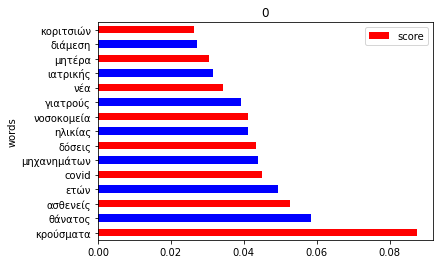

          words     score
0     κρούσματα  0.087471
1       θάνατος  0.058523
2      ασθενείς  0.052798
3          ετών  0.049419
4         covid  0.044936
5   μηχανημάτων  0.043992
6        δόσεις  0.043405
7       ηλικίας  0.041243
8    νοσοκομεία  0.041189
9      γιατρούς  0.039127
10          νέα  0.034204
11     ιατρικής  0.031453
12       μητέρα  0.030443
13      διάμεση  0.027263
14    κοριτσιών  0.026445


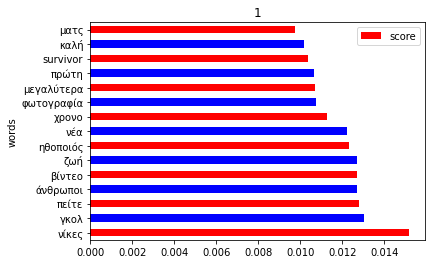

         words     score
0        νίκες  0.015195
1         γκολ  0.013025
2        πείτε  0.012822
3     άνθρωποι  0.012731
4       βίντεο  0.012713
5          ζωή  0.012701
6     ηθοποιός  0.012323
7          νέα  0.012212
8        χρονο  0.011273
9   φωτογραφία  0.010755
10  μεγαλύτερα  0.010694
11       πρώτη  0.010672
12    survivor  0.010378
13        καλή  0.010188
14        ματς  0.009770


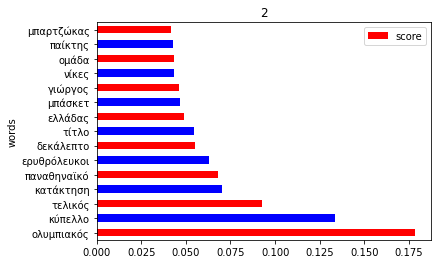

           words     score
0     ολυμπιακός  0.178615
1        κύπελλο  0.133398
2        τελικός  0.092852
3      κατάκτηση  0.070347
4    παναθηναϊκό  0.067836
5   ερυθρόλευκοι  0.063069
6      δεκάλεπτο  0.055345
7          τίτλο  0.054701
8        ελλάδας  0.049117
9        μπάσκετ  0.046710
10       γιώργος  0.046033
11         νίκες  0.043543
12         ομάδα  0.043389
13       παίκτης  0.043008
14    μπαρτζώκας  0.041703


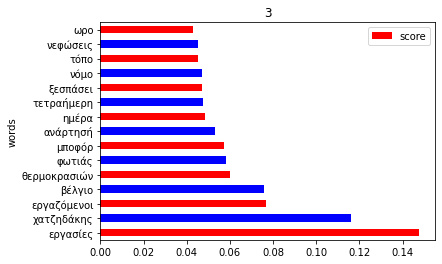

           words     score
0       εργασίες  0.147766
1     χατζηδάκης  0.116239
2    εργαζόμενοι  0.076587
3         βέλγιο  0.075590
4   θερμοκρασιών  0.059842
5         φωτιάς  0.058379
6         μποφόρ  0.057483
7       ανάρτησή  0.053025
8          ημέρα  0.048242
9     τετραήμερη  0.047598
10      ξεσπάσει  0.047180
11          νόμο  0.047069
12          τόπο  0.045247
13      νεφώσεις  0.045075
14           ωρο  0.042908


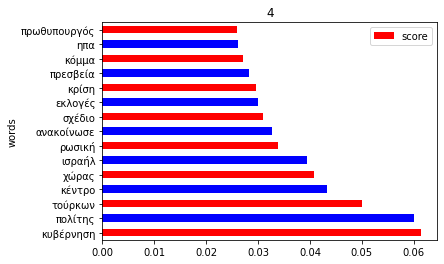

           words     score
0      κυβέρνηση  0.061472
1        πολίτης  0.060124
2        τούρκων  0.049984
3         κέντρο  0.043260
4          χώρας  0.040713
5         ισραήλ  0.039408
6         ρωσική  0.033885
7     ανακοίνωσε  0.032647
8         σχέδιο  0.030894
9        εκλογές  0.029977
10         κρίση  0.029582
11      πρεσβεία  0.028177
12         κόμμα  0.027127
13           ηπα  0.026157
14  πρωθυπουργός  0.025861


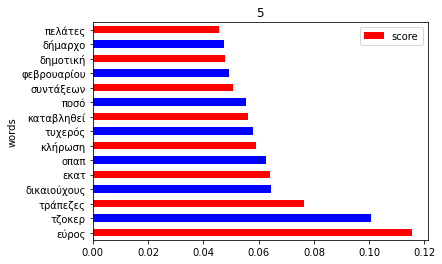

          words     score
0         εύρος  0.115387
1        τζοκερ  0.100499
2      τράπεζες  0.076582
3   δικαιούχους  0.064529
4          εκατ  0.064021
5          οπαπ  0.062688
6       κλήρωση  0.059095
7       τυχερός  0.058132
8    καταβληθεί  0.056216
9          ποσό  0.055388
10    συντάξεων  0.050870
11  φεβρουαρίου  0.049389
12     δημοτική  0.047798
13      δήμαρχο  0.047639
14      πελάτες  0.045779


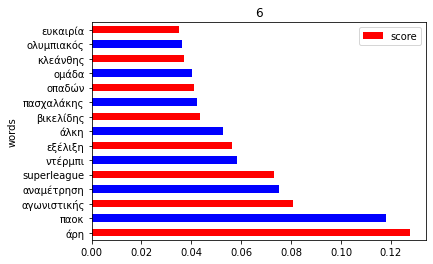

          words     score
0           άρη  0.127789
1          παοκ  0.117889
2   αγωνιστικής  0.080653
3    αναμέτρηση  0.075020
4   superleague  0.072941
5       ντέρμπι  0.058474
6       εξέλιξη  0.056232
7          άλκη  0.052733
8     βικελίδης  0.043353
9    πασχαλάκης  0.042432
10       οπαδών  0.041173
11        ομάδα  0.040225
12     κλεάνθης  0.036854
13   ολυμπιακός  0.036084
14     ευκαιρία  0.034926


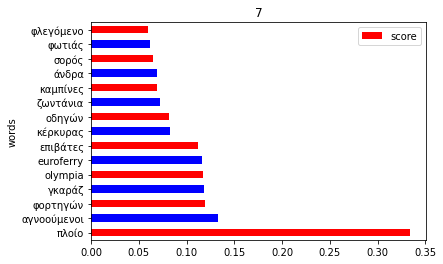

          words     score
0         πλοίο  0.333853
1   αγνοούμενοι  0.132800
2      φορτηγών  0.119064
3        γκαράζ  0.118258
4       olympia  0.117438
5     euroferry  0.115880
6      επιβάτες  0.112344
7      κέρκυρας  0.082210
8        οδηγών  0.081335
9      ζωντάνια  0.072198
10     καμπίνες  0.069346
11        άνδρα  0.069056
12        σορός  0.064417
13       φωτιάς  0.061196
14    φλεγόμενο  0.059153


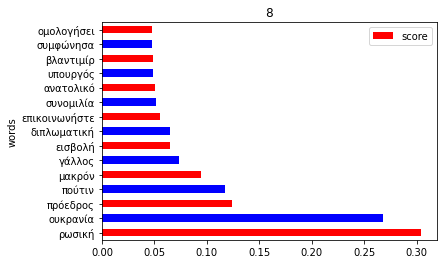

            words     score
0          ρωσική  0.303994
1        ουκρανία  0.267518
2        πρόεδρος  0.124316
3          πούτιν  0.117713
4          μακρόν  0.094809
5          γάλλος  0.073363
6         εισβολή  0.065078
7     διπλωματική  0.064506
8   επικοινωνήστε  0.054938
9       συνομιλία  0.051556
10      ανατολικό  0.050297
11       υπουργός  0.049058
12      βλαντιμίρ  0.048668
13      συμφώνησα  0.047354
14     ομολογήσει  0.047277


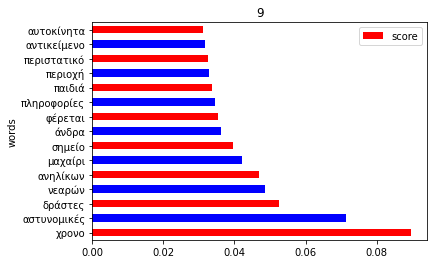

          words     score
0         χρονο  0.089678
1   αστυνομικές  0.071328
2       δράστες  0.052588
3        νεαρών  0.048681
4      ανηλίκων  0.046944
5       μαχαίρι  0.042167
6        σημείο  0.039538
7         άνδρα  0.036153
8       φέρεται  0.035522
9   πληροφορίες  0.034557
10       παιδιά  0.033774
11      περιοχή  0.032726
12  περιστατικό  0.032563
13  αντικείμενο  0.031798
14   αυτοκίνητα  0.031229


In [ ]:


prediction = km.predict(dtm_tfidf) # προβλέπει την πλησιέστερη ομάδα που ανήκει κάθε μια από τις ειδήσεις
# συνάρτηση για στατιστικά και γραφήματα από την ομαδοποίηση ειδήσεων
def get_top_words_cluster(tf_idf_array, prediction, n_w):
    labels = np.unique(prediction)
        
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indexes  για κάθε cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # επιστρέφει τη μέση βαθμολογία στο cluster
        sorted_means = np.argsort(x_means)[::-1][:n_w] # indexes με τις top 15 βαθμολογίες
        features = tfidf_vectorizer.get_feature_names_out()
        top_words=[]
        # εμφάνιση ολόκληρων των λέξεων και όχι των αποκομμένων
        for i in sorted_means:
           if len(vocab_frame.loc[features[i],'words'][0])==1:
             t=(vocab_frame.loc[features[i],'words'], x_means[i])
           else:
             t=(vocab_frame.loc[features[i],'words'][0], x_means[i])
           top_words.append(t) 
        df = pd.DataFrame(top_words, columns = ['words', 'score']) # δημιουργία dataframe με στήλες τις λέξεις και τη βαθμολογία
        df.plot.barh(x ='words', y='score', color=['red','blue'])	# γραφική αναπαράσταση του dataframe
        plt.title(label)
        plt.show()
        print(df)
        dfs.append(df)
get_top_words_cluster(dtm_tfidf.toarray(), prediction, 15)


# LDA Visualization

In [ ]:
from __future__ import print_function

!pip install pyldavis==2.1.2
import pyLDAvis
import pyLDAvis.sklearn
import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import LatentDirichletAllocation

     |████████████████████████████████| 1.6 MB 5.2 MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97738 sha256=4763fb7ee78d4174961e52d8a3585e29d492716866b1aef99f7d8758853db3de
  Stored in directory: /root/.cache/pip/wheels/3b/fb/41/e32e5312da9f440d34c4eff0d2207b46dc9332a7b931ef1e89
Successfully built pyldavis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Μετατροπή της συλλογής των ειδήσεων σε έναν tf matrix

In [ ]:
tf_vectorizer = CountVectorizer(analyzer='word', stop_words=stopWords, 
                             lowercase=True,tokenizer=tokenize_and_stem)
dtm_tf = tf_vectorizer.fit_transform(df['content'].tolist())
 

Δημιουργία lda μοντέλου και οπτικοποίηση των topics

In [ ]:
# topic modelling - 20 topics
lda_tf = LatentDirichletAllocation(n_components=20,max_iter=20, random_state=20)
lda_tf.fit(dtm_tf)
# οπτικοποίηση των topics
pyLDAvis.enable_notebook()
vis=pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer) 
display(pyLDAvis.display(vis))

 


# Faiss search

In [ ]:
!pip install faiss-gpu
!pip install -U sentence-transformers


import numpy as np
import torch
import os
import pandas as pd
import faiss
import time
from sentence_transformers import SentenceTransformer

     |████████████████████████████████| 85.5 MB 112 kB/s 
     |████████████████████████████████| 79 kB 3.7 MB/s 
     |████████████████████████████████| 3.5 MB 11.0 MB/s 
     |████████████████████████████████| 1.2 MB 46.7 MB/s 
     |████████████████████████████████| 67 kB 4.4 MB/s 
     |████████████████████████████████| 596 kB 49.2 MB/s 
     |████████████████████████████████| 6.8 MB 43.8 MB/s 
     |████████████████████████████████| 895 kB 68.7 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=a957f0b367efcfc74e559b2acb8dd2efc0f103c7f0d9097050cac6345e45d3f5
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# λήψη του μοντέλου 'sn-xlm-roberta-base-snli-mnli-anli-xnli' και δημιουργία embeddings
model = SentenceTransformer('symanto/sn-xlm-roberta-base-snli-mnli-anli-xnli')
data=df.content.to_list()
encoded_data = model.encode(data)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.72k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/677 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/356 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Αποθήκευση των sentence embeddings σε έναν faiss index
index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index.add_with_ids(encoded_data, np.array(range(0, len(data))))

In [ ]:
#Αλλαγή από cpu σε gpu
res = faiss.StandardGpuResources()
gpu_index = faiss.index_cpu_to_gpu(res, 0, index)

RuntimeError: ignored

# Εγκατάσταση ElasticSearch

Εγκατάσταση elasticsearch server version 7.12.0. 

In [ ]:
!apt install default-jdk > /dev/null
!wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.12.0-linux-x86_64.tar.gz -q --show-progress
!tar -xzf elasticsearch-7.12.0-linux-x86_64.tar.gz
!chown -R daemon:daemon elasticsearch-7.12.0



elasticsearch-7.12. 100%[===================>] 312.33M  42.2MB/s    in 8.5s    



Εκκίνηση του Elasticsearch Server

In [ ]:
import os
from subprocess import Popen, PIPE, STDOUT
es_server = Popen(['elasticsearch-7.12.0/bin/elasticsearch'], 
                  stdout=PIPE, stderr=STDOUT,
                  preexec_fn=lambda: os.setuid(1)  # as daemon
                 )

In [ ]:
# Αναμονή για λίγα δευτερόλεπτα μέχρι να ξεκινήσει ο server.
import time
time.sleep(20)

Εγκατάσταση του Elasticsearch client και έλεγχος αν ο client μπορεί να έχει πρόσβαση στον Elasticsearch server.Εκτέλεση δύο φορές αν χρειάζεται, ώστε να δώσουμε χρόνο στον server να ξεκινήσει.

In [ ]:
!pip install elasticsearch==7.12.0 -q
from elasticsearch import Elasticsearch
es = Elasticsearch("http://localhost:9200")
es.ping()  # πρέπει να λάβουμε True

     |████████████████████████████████| 334 kB 5.6 MB/s 


True

Έλεγχος αν το elasticsearch δουλεύει κανονικά 

In [ ]:
!curl -X GET "localhost:9200/"

{
  "name" : "20d4b224687f",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "l0fpJQzdS4OlQlM3x3EOzg",
  "version" : {
    "number" : "7.12.0",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "78722783c38caa25a70982b5b042074cde5d3b3a",
    "build_date" : "2021-03-18T06:17:15.410153305Z",
    "build_snapshot" : false,
    "lucene_version" : "8.8.0",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [ ]:
# λήψη του μοντέλου 'sn-xlm-roberta-base-snli-mnli-anli-xnli' και δημιουργία embeddings
model = SentenceTransformer('symanto/sn-xlm-roberta-base-snli-mnli-anli-xnli')

# Προσθήκη των ειδήσεων στον ElasticSearch index

In [ ]:
# Σύνδεση στο elasticsearch 
es = Elasticsearch("http://localhost:9200")
#διαγραφή του  index αν υπάρχει ήδη
es.indices.delete(index='news_index', ignore=[400, 404])
# δημιουργία του index ανα δεν υπάρχει
try:
    request_body = {
        "settings" : {
            "number_of_shards": 1,
            "number_of_replicas": 1
        },

        "mappings": {
            "properties": {
                "title": {"type": "text"},
                "category": {"type": "text"},
                "description": {"type": "text"},
                "link": {"type":  "text"},
                "pubDate": {"type": "text"},
                "body": {"type": "text"},
                "body_vector": {"type":  "dense_vector", "dims":  768}
            }
        }
    }
    es.indices.create(index = 'news_index', body = request_body)
except:
    pass

# Προσθήκη κάθε άρθρου είδήσεων στο index. 
for i in range(len(df)):
            news = {
                'title': df['title'][i],
                'category':df['category'][i],
                'description': df['description'][i],
                'link': df['link'][i],
                'body': df['content'][i],
                'body_vector': model.encode(df['content'][i], convert_to_tensor=True).tolist(),
                'pubDate': df['pubDate'][i]
                }
            res = es.index(index="news_index", id=i, body=news)
            
time.sleep(1)
res=es.get(index='news_index',id=1)
print(res)
print('Process complete')


{'_index': 'news_index', '_type': '_doc', '_id': '1', '_version': 1, '_seq_no': 1, '_primary_term': 1, 'found': True, '_source': {'title': 'Μεσσηνία: Χτύπησαν τον 73χρονο με “κάβουρα” και τον στραγγάλισαν – Νέα στοιχεία για τη φρικτή δολοφονία', 'category': 'κοινωνία', 'description': 'Στυγερό έγκλημα με θύμα έναν 73χρονο άνδρα, συγκλονίζει τη Μεσσηνία. Ένας πατέρας και οι δύο γιοι του, συνελήφθησαν από τις αστυνομικές Αρχές ως οι δράστες της δολοφονίας του άτυχου ηλικιωμένου, όπως αναφέρουν σχετικές πληροφορίες. Ο 73χχρονος βρέθηκε νεκρός από συγγενικό του πρόσωπο, μέσα στο κτήμα του στο Τζάνε της Δ.Ε. Πεταλιδίου του δήμου Μεσσήνης, το [&#8230;]', 'link': 'https://www.enikos.gr/society/messinia-chtypisan-ton-73chrono-me-kavoura-kai-ton-strangalisan-nea-stoicheia-gia-ti-frikti-dolofonia/1758949/', 'body': 'Στυγερό έγκλημα με θύμα έναν 73χρονο άνδρα, συγκλονίζει τη Μεσσηνία. Ένας πατέρας και οι δύο γιοι του, συνελήφθησαν από τις αστυνομικές Αρχές ως οι δράστες της δολοφονίας του άτυχου η

In [ ]:
!curl -X GET "localhost:9200/news_index/_search"?pretty=true

{
  "took" : 1158,
  "timed_out" : false,
  "_shards" : {
    "total" : 1,
    "successful" : 1,
    "skipped" : 0,
    "failed" : 0
  },
  "hits" : {
    "total" : {
      "value" : 510,
      "relation" : "eq"
    },
    "max_score" : 1.0,
    "hits" : [
      {
        "_index" : "news_index",
        "_type" : "_doc",
        "_id" : "89",
        "_score" : 1.0,
        "_source" : {
          "title" : "ΗΠΑ: Έως και 190.000 τα ρωσικά στρατεύματα στην Ουκρανία",
          "category" : " ",
          "description" : "Η συσσώρευση στρατιωτικού προσωπικού από τη Ρωσία που απειλεί την Ουκρανία πιθανότατα ανέρχεται συνολικά σε 190.000, δήλωσε ο πρεσβευτής των ΗΠΑ στον Οργανισμό για την Ασφάλεια και τη Συνεργασία στην Ευρώπη (ΟΑΣΕ) σε δήλωση σε συνεδρίαση του ΟΑΣΕ για την ουκρανική κρίση την Παρασκευή.",
          "link" : "https://www.naftemporiki.gr/story/1833759/ipa-eos-kai-190000-ta-rosika-strateumata-stin-oukrania",
          "body" : "Η συσσώρευση στρατιωτικού προσωπικού από τη Ρω

In [ ]:
!curl -X GET "localhost:9200/_cat/indices?v"

health status index      uuid                   pri rep docs.count docs.deleted store.size pri.store.size
yellow open   news_index Yj11uVe_QQub57M3ht93Jg   1   1        510            0      9.5mb          9.5mb


#Συνάρτηση για την εύρεση των ειδήσεων

In [ ]:
def find_news(user_input, search):
  if search=="elsearch": # αν έχει επιλεγεί αναζήτηση με elasticsearch
    es = Elasticsearch()
    SEARCH_SIZE = 10 # Μέγιστος αριθμός αποτελεσμάτων που θα επιστραφούν
    query_vector = model.encode(user_input, convert_to_tensor=True).tolist() # δημιουργία embeddings από το ερώτημα που υποβάλλεται
    print(query_vector[0:10])
    # χρήση του ερωτήματος
    script_query = {
            "script_score": {
                "query": {"match_all": {}},
                "script": {
                    "source": "cosineSimilarity(params.query_vector, 'body_vector') + 1.0",
                    "params": {"query_vector": query_vector}
                }
            }
        }

        # αναζήτηση στο index
    res = es.search(
        index='news_index',  # το όνομα του index
        body={
            "size": SEARCH_SIZE,
            "query": script_query,
            "_source": {"includes": ["title", "body", "body_vector", "link"]}
            }
        )

    # δημιουργία λίστας με τις ειδήσεις που βρέθηκαν
    news = []
    header='<h2>Matches to query: {input} </h2>'
    news.append(header.format(input=user_input))
    base_element = '<a href="{url}">{title}</a> - <b>News</b>: <i>{body}</i>'
    for hit in res['hits']['hits']:
        news.append(base_element.format(url=hit['_source']['link'], title=hit['_source']['title'],body=hit['_source']['body']))
    return news
  else:  #αν έχει επιλεγεί αναζήτηση με faiss
    t=time.time()
    query_vector = model.encode([user_input])
    k = 10
    top_k = index.search(query_vector, k)
    print(top_k)
    results=top_k[1].tolist()[0]
   
    print('totaltime: {}'.format(time.time()-t))
    # δημιουργία λίστας με τις ειδήσεις που βρέθηκαν
    news = []
    header='<h2>Matches to query: {input} </h2>'
    news.append(header.format(input=user_input))
    base_element =  '<a href="{url}">{title}</a> - <b>News</b>: <i>{body}</i>'
    for _id in top_k[1].tolist()[0]:
        news.append(base_element.format(url=df['link'][_id], title=df['title'][_id],body=df['content'][_id]))   
    
    return news


# Εκκίνηση της διεπαφής χρήστη

In [ ]:
!pip install flask-ngrok
!pip install flask==0.12.2  # Νεότερες εκδόσεις του flask δεν δουλεύουν στο  Colab
                            # Βλέπε https://github.com/plotly/dash/issues/257

!pip install pyngrok



     |████████████████████████████████| 83 kB 788 kB/s 
  Attempting uninstall: flask
    Found existing installation: Flask 1.1.4
    Uninstalling Flask-1.1.4:
      Successfully uninstalled Flask-1.1.4
     |████████████████████████████████| 745 kB 4.9 MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.1.0-py3-none-any.whl size=19007 sha256=f2d33e000ea85e6cc217893c36532d9a83ffedbe5cb5513d18cbd5b27602a3a5
  Stored in directory: /root/.cache/pip/wheels/bf/e6/af/ccf6598ecefecd44104069371795cb9b3afbcd16987f6ccfb3
Successfully built pyngrok


In [ ]:
from pyngrok import ngrok
!ngrok authtoken 22f2I1Y6Jkb0FSVz8J6kgWu9GPc_y3BHnWUbv3CA8NAWQy9L # αποθήκευση του κλειδιού Authtoken στο αρχείο ρυθμίσεων ngrok.yml 
from flask import Flask, request, render_template
from flask_ngrok import run_with_ngrok
from google.colab import drive
# στο drive υπάρχει ο φάκελος templates με τα αρχεια index.htlm και results.html
drive.mount('/content/drive')
app = Flask(__name__,template_folder='/content/drive/My Drive/templates') 

run_with_ngrok(app)
@app.after_request
def after_request(response):
    response.headers["Cache-Control"] = "no-cache, no-store, must-revalidate, public, max-age=0"
    response.headers["Expires"] = '0'
    response.headers["Pragma"] = "no-cache"
    return response

# σελίδα Index
@app.route('/', methods=['get', 'post'])            

def index_page():
    return render_template('index.html')

# Λήψη δεδομένων από τη φόρμα στη σελίδα index, και πέρασμα αυτών στη συνάρτηση find_news()
@app.route('/results', methods=['get', 'post'])
def results_page():
    if request.method == 'POST':
        user_input = request.form["user_input"]
        print(user_input)
        check = request.form["search"]
        if check=="elsearch": # αν έχει επιλεγεί αναζήτηση με elasticsearch
           search="elsearch" 
        else:
           search="faiss"  # αν έχει επιλεγεί αναζήτηση με faiss
               
        news = find_news(user_input,search)       
        return render_template('results.html',data=news)  # επιστροφή της σελίδας results.html με τα αποτελέσματα αναζήτησης
    else:
        return "An error was encountered"
if __name__ == '__main__':
    app.run()

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


Mounted at /content/drive
 * Running on http://ac94-35-196-37-205.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [20/Feb/2022 21:59:48] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [20/Feb/2022 21:59:49] "GET /favicon.ico HTTP/1.1" 404 -


φωτιά στο πλοίο
(array([[150.7643  , 140.39769 , 140.39769 , 136.69865 , 123.799736,
        123.46625 , 122.904396, 116.70681 , 114.06594 , 113.68488 ]],
      dtype=float32), array([[553,  44,  38, 216, 365, 173, 526, 414, 547, 564]]))
totaltime: 0.1338481903076172


127.0.0.1 - - [20/Feb/2022 22:00:08] "POST /results HTTP/1.1" 200 -


In [ ]:
df